In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [16]:
import numpy as np
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.experiment import build_environment

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


In [17]:

def run_policy(env, policy, nx, step_duration, max_steps=1000):
    """
    Run the simulation using a given policy with a maximum number of steps.

    Args:
        env: The environment with network properties.
        policy: The control policy to be used.
        nx: Number of grid points per dimension (used for mapping states to grid indices).
        step_duration: Duration of each policy application.
        tolerance: Tolerance for the mean opinion to stop the simulation.
        max_steps: Maximum number of steps to run.

    Returns:
        opinions_over_time: Array of opinions over the entire simulation.
        time_points: Corresponding time points for each opinion snapshot.
        rewards_over_time: Collected rewards at each step.
    """
    N = env.num_agents
    time_points = []
    rewards_over_time = []
    current_time = 0.0
    state, _ = env.reset()
    opinions_over_time = [state]
    grids = create_state_grid(N, nx)

    for step in range(max_steps):
        idx = tuple(np.abs(grids[i] - state[i]).argmin() for i in range(N))
        action = policy.get(idx, np.zeros(N))
        
        # print(action)
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        # print(f"Step: {step}, Time: {current_time}, Reward: {reward}")
        
        current_time += step_duration
        state = next_state

        if done or truncated:
            print(f"Ran for {step} steps: done={done}, truncated={truncated}")
            break
    
    print(f"Ran for {step} steps: done={done}, truncated={truncated}")
    return np.array(opinions_over_time), np.array(time_points), np.array(rewards_over_time)


c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


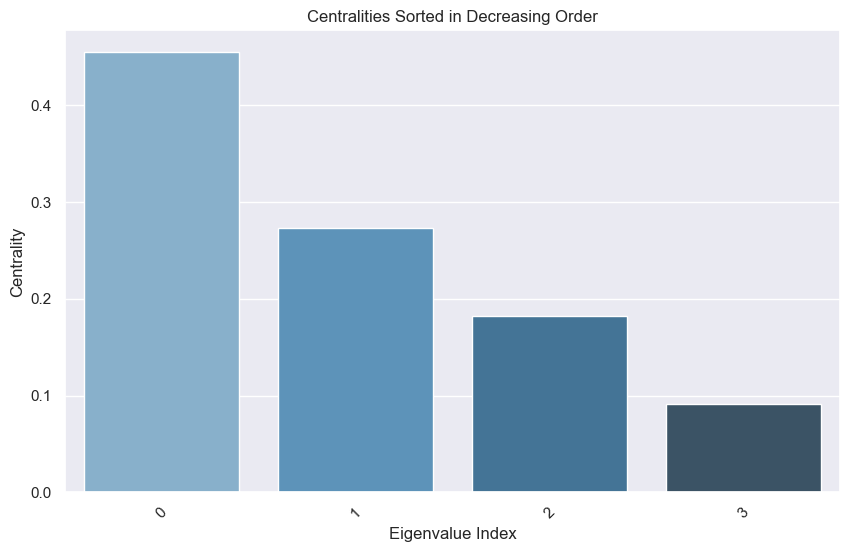

In [18]:
env = build_environment()
env.render(mode="centralities")

Ran for 5 steps: done=True, truncated=False
Ran for 5 steps: done=True, truncated=False


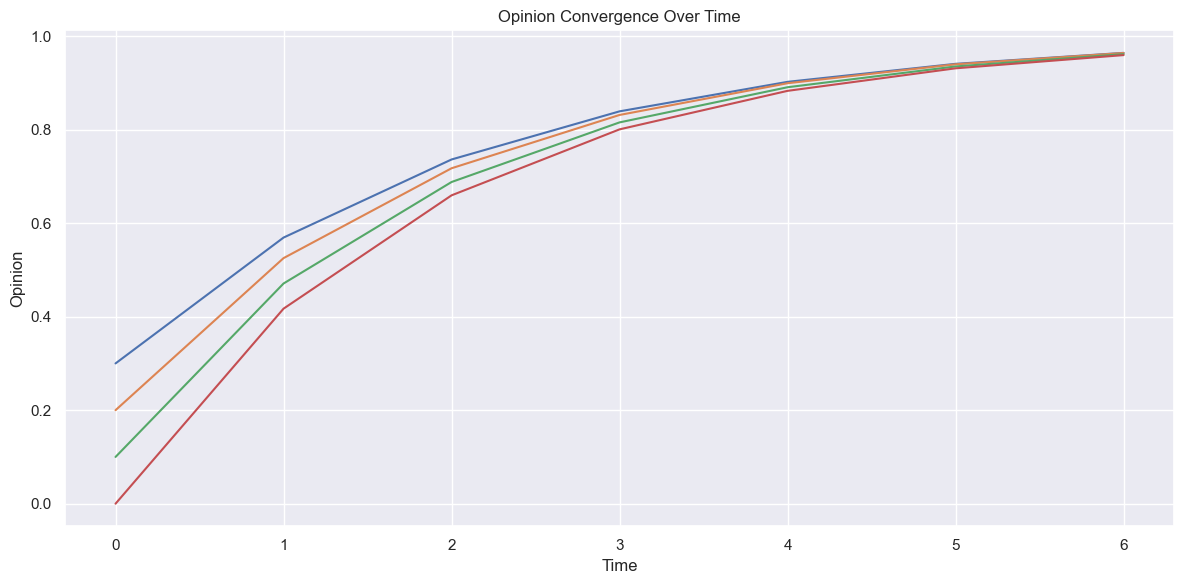

-1.3240206662711445

In [19]:

num_steps = 100
nx = 8

policy_broadcast = generate_full_control_policy(env, nx)

opinions_over_time, time_points, rewards = run_policy(env, policy_broadcast, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)

# sum(rewards)

gamma = 0.9

total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

In [20]:
sum(rewards)

-1.4535585427721212

In [21]:
opinions_over_time

array([[0.3       , 0.2       , 0.1       , 0.        ],
       [0.56912426, 0.52516641, 0.47089255, 0.41709435],
       [0.73613489, 0.71734292, 0.68793322, 0.65943037],
       [0.83906291, 0.83134788, 0.81545381, 0.80053418],
       [0.902157  , 0.8991852 , 0.89062395, 0.88289149],
       [0.94066956, 0.93964955, 0.93505513, 0.93108128],
       [0.96409826, 0.96383278, 0.96137677, 0.95934964]])

In [22]:
env = build_environment()

# Adjusted parameters
beta = env.control_beta
gamma = 0.9
step_duration = env.tau

V = value_iteration(env, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration)
policy = extract_policy(
    env, V, nx=nx, gamma=gamma, beta=beta, step_duration=step_duration
)

Converged in 17 iterations.


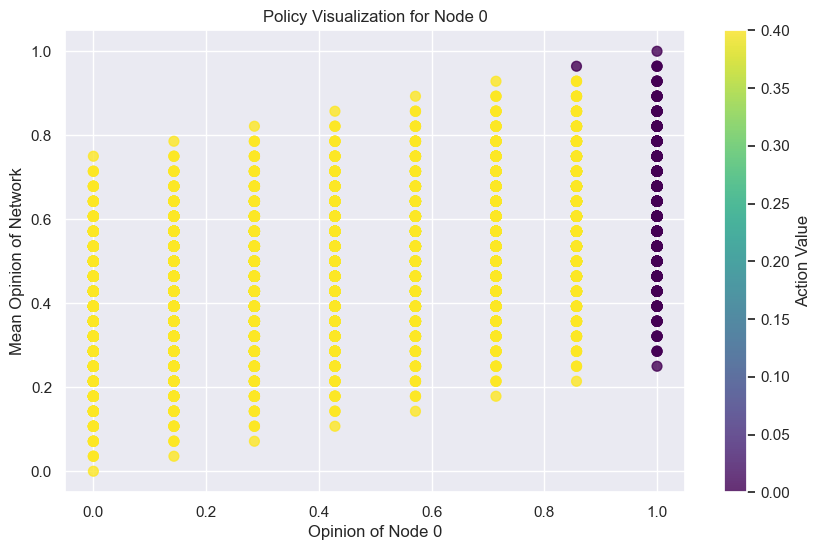

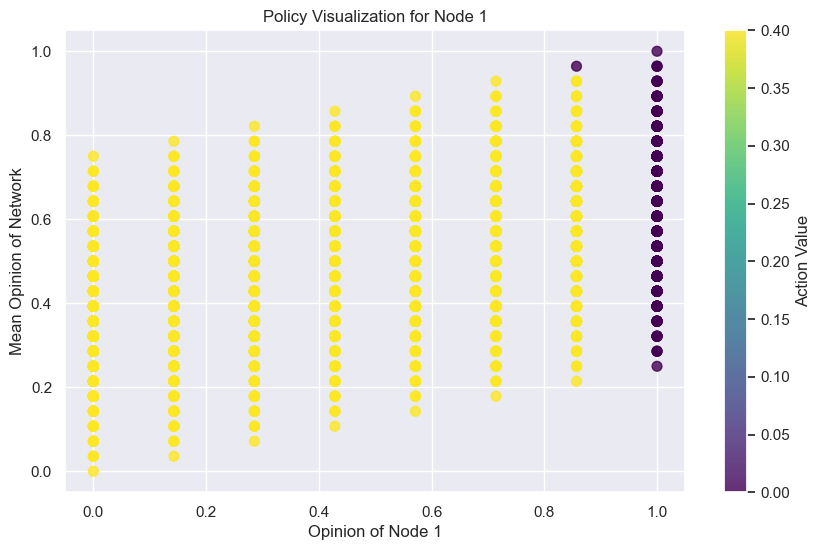

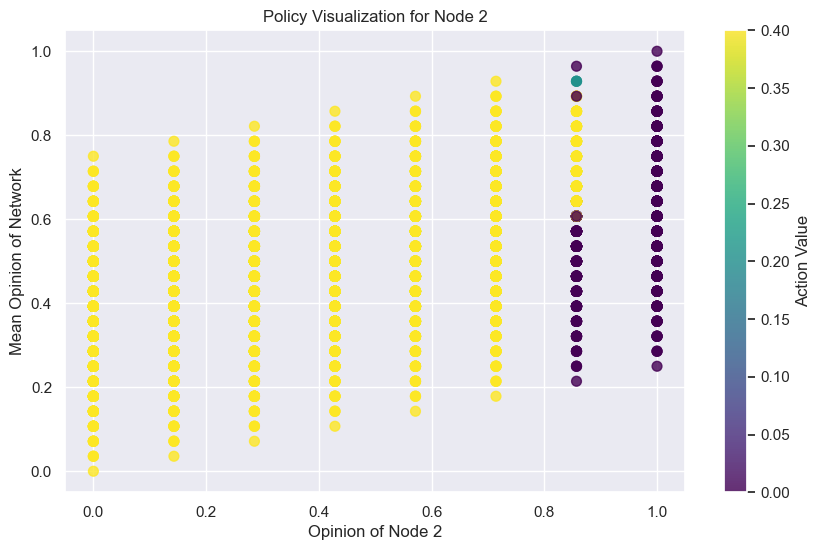

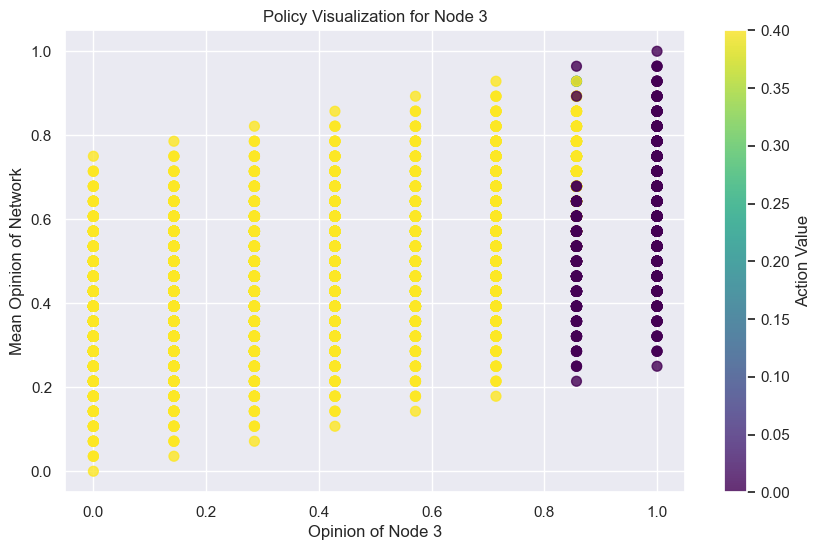

In [23]:
for node_index in range(env.num_agents):
    visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

Ran for 6 steps: done=False, truncated=False


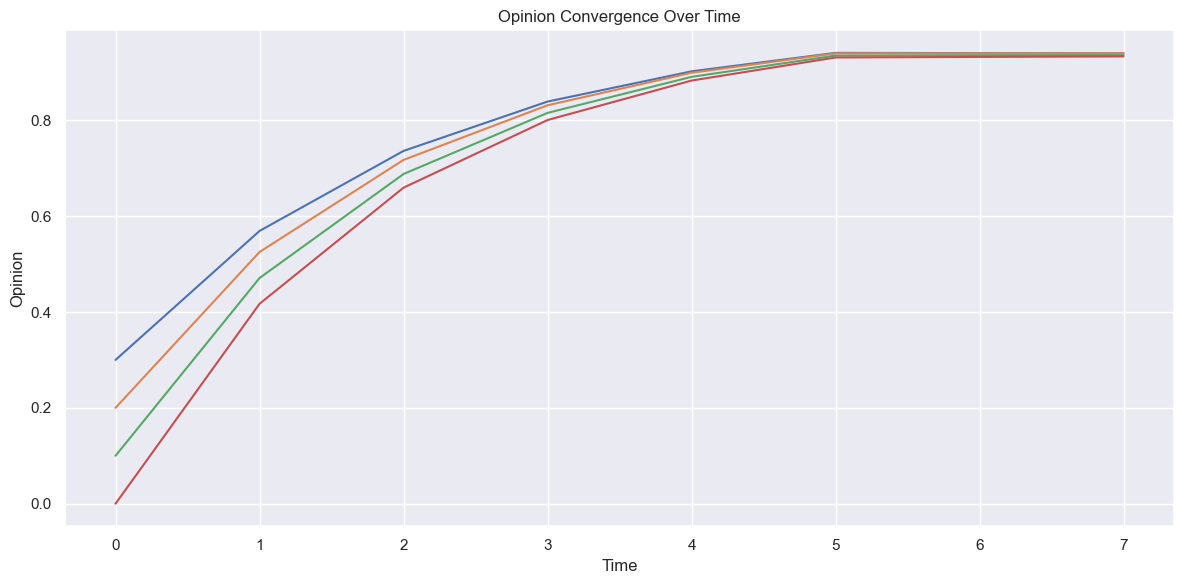

-1.5203731915699596

In [24]:
env = build_environment()
num_steps = 7

opinions_over_time, time_points, rewards = run_policy(env, policy, nx=nx, step_duration=env.tau, max_steps=num_steps)
plot_opinions_over_time(opinions_over_time)
# sum(rewards)

total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r
    
total_value

In [25]:
env.opinions

array([0.93975612, 0.93974298, 0.93611053, 0.93325738])

In [26]:
rewards

array([-0.57278501, -0.39637039, -0.2917244 , -0.22955654, -0.19257424,
       -0.05436155, -0.05412349])

### DQN: 
Distributes budget beta_k (beta can be selected from discrete interval) across all nodes using W*
beta_k to be chosen constant

###  NAHS 
Distributes total budget B across M campaigns
At each campaign distributes the budget beta_k across all nodes using W_k
distribute the same beta_k as in the dqn experiment, and track